## CMSC 197 (Machine Learning)
<p>"Assignment 4 - Naive Bayes Spam Filter"</p>
<p>by Hismaña, Nikko Gabriel (2009-48594)</p>

### 0. FILES and SET SPLITTING

Files included/used for this notebook:
<li>stop_words.txt - list of stop words
<li>trec06c-cs280 - dataset containing emails as Files
directory: trec06c-cs280/data/000~126 <p>

<p>Training Set: All files from 000 to 070
<p>Test Set: All files from 071 to 126

### I. PREPROCESSING (10pts)

#### I.A. Importing the necessary libraries

In [1]:
### standard libraries (allowed as per instructions)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### SKLearn libraries (allowed as per instructions)
# only to be used for:
# -Preprocessing
# -Model Evaluationg
# -Comparison (of Naive Bayes from Scratch) with Naive Bayes of SKLEARN
from sklearn.model_selection import train_test_split # for splitting data
from sklearn.metrics import confusion_matrix # for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # for evaluation
from sklearn.naive_bayes import GaussianNB # for comparison with Naive Bayes from Scratch

#### I.B. Importing the dataset and stop words

In [39]:
# Import the dataset
# dataset is composed of files in "trec06p-cs280\data" folder, divided into subfolders 000 to 126, total emails: 37,822

import os

# path to the dataset
data_path = "trec06p-cs280\data\\"
labels_path = "trec06p-cs280\labels"

# put labels into a numpy array
# remember that labels is just a single file with the format ham ../data/000/000 or spam ../data/000/001
# numpy array should be in order of folder number and file number: labels[0] = 000/000, labels[1] = 000/001, ..., labels[37821] = 126/021
# labels should have format ([(ham/spam, 000/000), (ham/spam, 000/001), ..., (ham/spam, 126/021)]), should not include "../data/":
# labels[0] = (ham/spam, 000/000), labels[1] = (ham/spam, 000/001), ..., labels[37821] = (ham/spam, 126/021)
# remove "../data/" from the path
labels = []
with open(labels_path, 'r') as f:
    # format should be labels[i] = (ham/spam, 000/000)
    for line in f:
        line = line.strip()
        # split line into ham/spam and 000/000
        line = line.split(" ")
        # remove "../data/" from the path
        line[1] = line[1][8:]
        # append to labels
        labels.append(tuple(line))
        
# path to stop_words.txt in same folder as this notebook
stop_words_path = "stop_words.txt"

# create list of stop words from stop_words.txt
stop_words = []
with open(stop_words_path, 'r') as f:
    for line in f:
        stop_words.append(line.strip())

# create a copy of original stop_words list
stop_words_orig = stop_words.copy()


In [3]:
# check first 10 stop words
print(stop_words[:5])

# print labels and their locations
print(labels[:5])

['a', 'able', 'about', 'above', 'abst']
[('ham', '000/000'), ('spam', '000/001'), ('spam', '000/002'), ('ham', '000/003'), ('spam', '000/004')]


#### I.C. Preprocessing the dataset

In [4]:
# Create numpy array of all emails 
# #(choosing to use numpy array instead of pandas dataframe since it is more efficient in terms of memory)
# format: emails[i] = (email_location ('folder\file'), email_label (spam or ham), email_text (body of email))
emails = np.empty((37822, 3), dtype=object)
for i in range(37822):
    # get email location
    email_locName = labels[i][1]
    # get email label
    email_label = labels[i][0]
    # get email text
    email_text = ""
    with open(data_path + email_locName, 'r', encoding='latin-1') as f:
        for line in f:
            email_text += line
    # append to emails
    emails[i] = (email_locName, email_label, email_text)

In [5]:
# DOUBLE CHECK numpy array of emails (check order, labels, and text)):
# print first 3 emails, with only 100 characters of text
for i in range(3):
    print(emails[i][0], emails[i][1], "\n", emails[i][2][:100])
# print last 3 emails, with only 100 characters of text
for i in range(37822-3, 37822):
    print(emails[i][0], emails[i][1], "\n", emails[i][2][:100])


000/000 ham 
 Received: from rodan.UU.NET by aramis.rutgers.edu (5.59/SMI4.0/RU1.4/3.08) 
	id AA23563; Mon, 27 Jul
000/001 spam 
 Received: from unknown (HELO groucho.cs.psu.edu) ([222.135.252.194]) by groucho.cs.psu.edu
	with SMT
000/002 spam 
 Received:
	from 24-151-178-89.dhcp.kgpt.tn.charter.com (HELO webmail.inet7.com.mail5.psmtp.com) ([24
126/019 spam 
 Received: from wonder.hananet.net (unknown [219.255.79.54])
	by kukui.ifa.hawaii.edu (8.11.7p2+Sun/8
126/020 spam 
 Received: from mail.csonline.com (unknown [61.133.225.142])
	by kukui.ifa.hawaii.edu (8.11.7p2+Sun/8
126/021 spam 
 Received: from 3F9CFCB8 (201-43-166-100.dsl.telesp.net.br [201.43.166.100])
	by kukui.ifa.hawaii.edu


#### I.D. Cleaning up email text

In [6]:
# function to remove stop words, websites, emails, numbers, and other non-words

# import regex and email libraries
import re
import email

def clean(emails, stop_words):
    # use email.message_from_string to parse email text
    # use email.get_payload to get body of email
    for i in range(len(emails)):
        # lower case all text and save as email_text
        # recall that email text is emails[i][2]
        emails[i][2] = emails[i][2].lower()
        # get email text
        email_text = emails[i][2] 
        # parse email text
        email_text = email.message_from_string(email_text)
        # get body of email (check for multipart emails) and decode
        # first get payload of email and decode
        # payload is the body of the email
        email_payload = email_text.get_payload(decode=True)
        if email_text.is_multipart():
            # iterate through email parts using walk()
            for part in email_text.walk():
                # extract content type of email
                content_type = part.get_content_type()
                # get content type of email using Content-Disposition
                cdispo = str(part.get('Content-Disposition'))
                # skip any text/plain (txt) attachments
                if content_type == 'text/plain' and 'attachment' not in cdispo:
                    email_text = part.get_payload()
                    break
        else:
            email_text = email_text.get_payload()
            if type(email_text) == bytes: # check if email_text is bytes
                email_text = email_text.decode('utf-8')
        # remove unnecessary characters and words
        # NOTE: there were additional removals apart from stop words, alphanumeric characters, and numbers
        # BUGFIX: avoid 'expected string or bytes-like object' error by checking if email_text is a string:
        # convert to string if not already:
        if type(email_text) == str:
            # remove all website links
            email_text = re.sub(r'http\S+', '', email_text)
            email_text = re.sub(r'www\S+', '', email_text)
            email_text = re.sub(r'bit.ly\S+', '', email_text)
            email_text = re.sub(r'bitly\S+', '', email_text)
            email_text = re.sub(r'goo.gl\S+', '', email_text)
            email_text = re.sub(r'goo\S+', '', email_text)
            # remove email addresses
            email_text = re.sub(r'\S+@\S+', '', email_text)
            # remove STOP WORDS
            email_text = email_text.split()
            email_text = [word for word in email_text if word not in stop_words]
            email_text = " ".join(email_text)
            # remove numbers using regex
            email_text = re.sub(r'\d+', '', email_text)
            # remove special characters and alphanumeric characters using regex
            email_text = re.sub(r'[^a-zA-Z\n ]', "", email_text)
            # remove any integers/numbers
            email_text = re.sub(r'\d+', '', email_text)
            # remove new line characters
            email_text = email_text.replace("\n", " ")
            # remove extra spaces
            email_text = re.sub(' +', ' ', email_text)
            # remove html tags (anything between < and >)
            email_text = re.sub(r'<[^>]+>', '', email_text)
            email_text = re.sub(r'</[^>]+>', '', email_text)
            # remove html formatting characters
            email_text = re.sub(r'&\S+;', '', email_text)
            # remove email formatting characters
            email_text = re.sub(r'[\w\.-]+@[\w\.-]+', '', email_text)
            # BUGFIX: remove stop words again (some stop words may have been added back in after removing punctuations)
            email_text = email_text.split()
            email_text = [word for word in email_text if word not in stop_words]
            email_text = " ".join(email_text)
        # save cleaned email text
        emails[i][2] = email_text
    return emails

In [7]:
# TEST clean function
# make copy of emails
emails_clean = []
emails_clean = emails.copy()

# call function to clean emails
emails_clean = clean(emails_clean, stop_words)

In [8]:
# PRINT results of clean function
# print first 3 emails with cleaned text
print(emails_clean[:3])
# print last 3 emails with cleaned text
print(emails_clean[-3:])
# print the size of the emails_clean numpy array
print(emails_clean.shape)

[['000/000' 'ham'
  'mailing list queried weeks ago running set archive server official list message moment joe buehler mailing list people desire serious orthodox discussion roman catholic religion assume will cater catholics provided operate guidelines interests doctrinal bent going limit list sort discussion participated usenet religion groups years primary observations catholics net religion well hope list help remedy problem extent net resource catholics religion moderation policy catholic church democracy monarchy subject divinely constitution set rules church parish priest bishop pope adhere christ set things appropriate call catholic argue affairs catholic simple follow teaching church moderation policy will reflect thinking plenty places net catholic doctrine freely attacked doubt subscribe list taste mailing list things interest set archive server interesting things moment unix software endeavors guys copyrighted planning setting quotation server email periodic interesting ci

#### I.E. Extract list of unique words

In [9]:
# extract unique words from emails
# function that creates dictionary of unique words and their counts

def count_unique_words(emails):
    unique_words = {}
    for i in range(len(emails_clean)):
        # get email text
        email_text = emails_clean[i][2]
        # avoid "Message" object has no attribute "split" error
        # by checking if email_text is a string
        if type(email_text) == str:
            email_text = email_text.split()
            # iterate through words in email text
            for word in email_text:
                # if word is not in unique_words, add it
                if word not in unique_words:
                    unique_words[word] = 1
                # if word is in unique_words, increment count
                else:
                    unique_words[word] += 1
    # get only the top 10,000 highest frequency words
    unique_words = dict(sorted(unique_words.items(), key=lambda item: item[1], reverse=True)[:10000]) # use reverse=True to sort in descending order
    return unique_words

In [10]:
# TEST count_unique_words function
unique_words = count_unique_words(emails_clean)

n = 5 #change this to print more or less words
# print first n words and their counts, per line:
for word, count in list(unique_words.items())[:n]:
    print(word, count)
print("...")
# print last n words and their counts, per line:
for word, count in list(unique_words.items())[-n:]:
    print(word, count)

bb 32899
td 26834
will 24933
tr 20487
br 16903
...
aggregate 44
terminated 44
lifestyle 44
breath 44
mentioning 44


#### I.E. Splitting the dataset into training and test sets

In [11]:
# Split into Three groups:
# -training set for ham
# -training set for spam
# -test set
# training set: folders 001 to 070 (total emails: 21,300)
# test set: folders 071 to 126 (total emails: 16,522)

# function to split emails_clean into training and test sets
def split_train_test(emails_clean):
    train_test_split = np.split(emails_clean, [21300]) # split at index 21300
    train_set = train_test_split[0]
    test_set = train_test_split[1]
    return train_set, test_set

In [12]:
# TEST split_train_test function
train_set, test_set = split_train_test(emails_clean)

# PRINT results of split_train_test function
print("Shape of Training Set: ", train_set.shape)
print("Shape of Test Set: ", test_set.shape)

# check the document at index 21300 (end of training set)
# this should be 070/299
print("Last email in training set:\n", train_set[-1])
# check the document at index 21301 (start of test set)
# this should be 071/000
print("\nFirst email in test set:\n",test_set[0])

Shape of Training Set:  (21300, 3)
Shape of Test Set:  (16522, 3)
Last email in training set:
 ['070/299' 'spam'
 'suffering pain depression heartburn help verified collected licensed online store great choice wonderful meds longawaited relief operative support fast shipping secure processing complete confidentiality store verified bbb approved visa']

First email in test set:
 ['071/000' 'spam'
 'hesitantly derive perverse satisfaction clodhopperhe called monica monicanow midwife mourn paycheck warranty']


### ======================

### II. CREATING THE FEATURE MATRICES (5pts)

In [13]:
# create feature matrix for spam and ham training sets numpy arrays
# remember that 0 or 1 indicates whether a word is present in an email, and then this is repeated for all emails and summed up for each word 
def create_feature_matrix(emails, unique_words):
    feature_matrix = np.zeros((len(emails), len(unique_words)))

    for i in range(len(emails)):
        # get email text
        email_text = emails[i]
        # avoid "Message" object has no attribute "split" error
        # by checking if email_text is a string
        if type(email_text) == str:
            email_text = email_text.split()
            # iterate through words in email text and check if word is in unique_words
            for word in email_text:
                # if the word is not in unique_words, move to next word
                if word not in unique_words:
                    continue
                if word in unique_words:
                    # get index of word in unique_words
                    word_index = list(unique_words.keys()).index(word)
                    # count word only once per email
                    feature_matrix[i][word_index] = int(1)
                    # once counted, move to next word
                    continue
    return feature_matrix


#### II.A Creating the feature matrix for the SPAM training sets

In [14]:
# create training set for spam
spam_train_set = train_set [train_set[:,1] == 'spam'] # use [:,1] to get the second column which is the label == 'spam'
spam_train_set_text = spam_train_set[:,2] # use [:,2] to get the third column which is the text

# create feature matrix for spam training set feature matrix
spam_train_set_feature_matrix = create_feature_matrix(spam_train_set_text, unique_words)

In [15]:
# print shape of spam training set feature matrix
print("Shape of Spam Training Set Feature Matrix: ", spam_train_set_feature_matrix.shape) 
# print words seen in spam training set:
print("Words in spam training set (Sample):")
for word, count in list(unique_words.items())[:10]:
    if spam_train_set_feature_matrix[:,list(unique_words.keys()).index(word)].sum() > 0:
        print(word, spam_train_set_feature_matrix[:,list(unique_words.keys()).index(word)].sum())

Shape of Spam Training Set Feature Matrix:  (13777, 10000)
Words in spam training set (Sample):
bb 940.0
td 692.0
will 2200.0
tr 726.0
br 674.0
width 931.0
received 298.0
email 449.0
subject 72.0
list 93.0


#### II.A Creating the feature matrix for the HAM training sets

In [16]:
# create training set for ham
ham_train_set = train_set [train_set[:,1] == 'ham'] # use [:,1] to get the second column which is the label == 'ham'
ham_train_set_text = ham_train_set[:,2] # get the third column which is the text

# create feature matrix for ham training set feature matrix
ham_train_set_feature_matrix = create_feature_matrix(ham_train_set_text, unique_words)

In [17]:
# print shape of HAM training set feature matrix
print("Shape of HAM Training Set Feature Matrix: ", ham_train_set_feature_matrix.shape) 
# print words seen in ham training set:
print("Words in HAM training set (Sample):")
for word, count in list(unique_words.items())[:10]:
    if ham_train_set_feature_matrix[:,list(unique_words.keys()).index(word)].sum() > 0:
        print(word, ham_train_set_feature_matrix[:,list(unique_words.keys()).index(word)].sum())


Shape of HAM Training Set Feature Matrix:  (7523, 10000)
Words in HAM training set (Sample):
bb 17.0
td 13.0
will 2304.0
tr 11.0
br 14.0
width 66.0
received 347.0
email 1446.0
subject 887.0
list 1006.0


### ======================

### III. COMPUTING THE PRIORS (5pts)

In [18]:
# Compute the prior probability of spam and ham
# P(spam) = number of spam emails / total number of emails
# P(ham) = number of ham emails / total number of emails

# get number of spam emails
spam_train_set_size = spam_train_set.shape[0]
# get number of ham emails
ham_train_set_size = ham_train_set.shape[0]
# get total number of emails
total_train_set_size = train_set.shape[0]

# print number of spam and ham emails
print("Number of spam emails: ", spam_train_set_size)
print("Number of ham emails: ", ham_train_set_size)

Number of spam emails:  13777
Number of ham emails:  7523


In [19]:
# compute prior probability of spam and ham
prior_spam = spam_train_set_size / total_train_set_size
prior_ham = ham_train_set_size / total_train_set_size

# print prior probability of spam and ham (decimal places: 4)
print(f"Prior probability of spam\nP(c=spam)= {prior_spam:.4f}")
print(f"\nPrior probability of ham\nP(c=ham)= {prior_ham:.4f}")

Prior probability of spam
P(c=spam)= 0.6468

Prior probability of ham
P(c=ham)= 0.3532


### ======================

### IV. COMPUTING THE LIKELIHOOD OF EACH WORD (15pts + 5pts for Laplace Smoothing)

In [20]:
# compute likelihood of spam and ham with Laplace smoothing
# P(word|spam) = (number of times word appears in spam emails + lambda_val) / (number of words in spam emails + (lambda_val * number of unique words))

# P(word|ham) = (number of times word appears in ham emails + lambda_val) / (number of words in ham emails + (lambda_val * number of unique words))

# using the feature matrix for spam and ham training sets, compute the number of times each word appears in spam and ham emails:
# number of times word appears in spam emails = sum of column in spam training set feature matrix
# number of times word appears in ham emails = sum of column in ham training set feature matrix

# compute number of words in spam emails
spam_train_set_words = spam_train_set_feature_matrix.sum()
# compute number of words in ham emails
ham_train_set_words = ham_train_set_feature_matrix.sum()

# print number of words in spam and ham emails
print("Number of words in spam emails: ", spam_train_set_words)
print("Number of words in ham emails: ", ham_train_set_words)


Number of words in spam emails:  413022.0
Number of words in ham emails:  349314.0


In [21]:
# function to compute likelihood 
def create_likelihood(lambda_val, set_feature_matrix, set_words, unique_words):
    # create dictionary to store likelihood
    likelihood = {}
    # iterate through unique words
    for word, count in unique_words.items():
        # get index of word in unique_words
        word_index = list(unique_words.keys()).index(word)
        # compute likelihood
        likelihood[word] = (set_feature_matrix[:,word_index].sum() + lambda_val) / (set_words + (lambda_val * len(unique_words)))
    return likelihood

In [22]:
# SET lambda val here:
lambda_val = 1

# TEST create_likelihood function
# create likelihood of spam and ham
likelihood_spam = create_likelihood(lambda_val, spam_train_set_feature_matrix, spam_train_set_words, unique_words)
likelihood_ham = create_likelihood(lambda_val, ham_train_set_feature_matrix, ham_train_set_words, unique_words)

In [23]:
# print likelihood of spam and ham for top N unique words
n = 5
print(f"Likelihood of spam for top {n} unique words:\n")
for word, count in list(unique_words.items())[:n]:
    print(f"P({word}|spam) = {likelihood_spam[word]}")
    # print the number of times the word appears in spam emails
    print(f"Number of times '{word}' appears in spam emails: {spam_train_set_feature_matrix[:,list(unique_words.keys()).index(word)].sum()}")


Likelihood of spam for top 5 unique words:

P(bb|spam) = 0.0022244705949099573
Number of times 'bb' appears in spam emails: 940.0
P(td|spam) = 0.0016382126697902237
Number of times 'td' appears in spam emails: 692.0
P(will|spam) = 0.005203039085437637
Number of times 'will' appears in spam emails: 2200.0
P(tr|spam) = 0.001718586740169542
Number of times 'tr' appears in spam emails: 726.0
P(br|spam) = 0.0015956616913541139
Number of times 'br' appears in spam emails: 674.0


In [24]:

print(f"\nLikelihood of ham for top {n} unique words:\n")
for word, count in list(unique_words.items())[:n]:
    # also print the number of times the word appears in ham emails
    print(f"P({word}|ham) = {likelihood_ham[word]}")
    print(f"Number of times '{word}' appears in ham emails: {ham_train_set_feature_matrix[:,list(unique_words.keys()).index(word)].sum()}")


Likelihood of ham for top 5 unique words:

P(bb|ham) = 5.00954596815042e-05
Number of times 'bb' appears in ham emails: 17.0
P(td|ham) = 3.89631353078366e-05
Number of times 'td' appears in ham emails: 13.0
P(will|ham) = 0.006415001920325954
Number of times 'will' appears in ham emails: 2304.0
P(tr|ham) = 3.33969731210028e-05
Number of times 'tr' appears in ham emails: 11.0
P(br|ham) = 4.17462164012535e-05
Number of times 'br' appears in ham emails: 14.0


### ======================

### V. CLASSIFYING THE EMAILS (10pts + 10pts for computing the log probabilities)

In [25]:
# classify training set emails

# create NB classifier function
# uses the prior probability of spam and ham, and the likelihood of spam and ham, and email text to classify the email as spam or ham, use log probabilities to avoid underflow
def classify_NB(email_text, prior_spam, prior_ham, likelihood_spam, likelihood_ham):
    # initialize log probabilities of spam and ham
    prob_spam = prior_spam
    prob_ham = prior_ham
    # iterate through words in email text
    for word in email_text.split():
        # if word is not in unique words, skip
        if word not in unique_words:
            continue
        # BUGFIX: avoid missing keyword error by:
        # 1. checking if word is in likelihood_spam
        # 2. checking if word is in likelihood_ham
        if word in likelihood_spam:
            # update log probability of spam
            prob_spam += np.log(likelihood_spam[word])
        if word in likelihood_ham:
            # update log probability of ham
            prob_ham += np.log(likelihood_ham[word])
        else:
            continue
        # if word in likelihood_spam and word in likelihood_ham:
        #     # update log probabilities of spam and ham
        #     prob_spam += np.log(likelihood_spam[word])
        #     prob_ham += np.log(likelihood_ham[word])
        # if word in unique_words:
        #     # update log probabilities of spam and ham
        #     prob_spam += np.log(likelihood_spam[word])
        #     prob_ham += np.log(likelihood_ham[word])
    # return spam or ham classification
    if prob_spam > prob_ham:
        return "spam"
    else:
        return "ham"


In [26]:
# test NB classifier function
# classify first email in training set
print("Classifying first email in training set:")
# remember this is numpy array, so you can't use .iloc:
print("Email Location: ", train_set[0][0]) # actual label
print("Actual Label: ", train_set[0][1]) # email location
print("Predicted label: ", classify_NB(train_set[0][2], prior_spam, prior_ham, likelihood_spam, likelihood_ham)) # predicted label

Classifying first email in training set:
Email Location:  000/000
Actual Label:  ham
Predicted label:  ham


In [27]:
# function to classify emails
def classify_all_NB(email_set, prior_spam, prior_ham, likelihood_spam, likelihood_ham):
    # create list to store actual labels
    actual_labels = []
    # create list to store predicted labels
    predicted_labels = []
    # iterate through entire training set
    for email in email_set:
        # BUGFIX: convert email text to string to avoid error
        email[2] = str(email[2])
        if type(email[2]) == str:
            # get actual label
            actual_label = email[1]
            # get predicted label
            predicted_label = classify_NB(email[2], prior_spam, prior_ham, likelihood_spam, likelihood_ham)
            # append actual label to actual_labels list
            actual_labels.append(actual_label)
            # append predicted label to predicted_labels list
            predicted_labels.append(predicted_label)
    # return actual labels and predicted labels
    return actual_labels, predicted_labels

### ======================

### VI. TESTING THE CLASSIFIER (10pts)

#### VI.A. Testing the classifier on the TRAINING SET

In [28]:
# call function to classify training set
actual_labels_train, predicted_labels_train = classify_all_NB(train_set, prior_spam, prior_ham, likelihood_spam, likelihood_ham)
actual = np.array(actual_labels_train)
predicted = np.array(predicted_labels_train)
correct = actual == predicted

# print number of correct predictions
print(f'Correctly Classified TRAIN SET: {sum(correct)}/{len(actual_labels_train)}')
print(f'Correct/Actual %: {sum(correct)/len(actual_labels_train):.4f}')

Correctly Classified TRAIN SET: 19844/21300
Correct/Actual %: 0.9316


In [29]:
# print as a table (columns: email location, actual label, predicted label)
n = 10

print(f"Email Location\tActual Label\tPredicted Label")
for i in range(n):
    print(f"{train_set[i][0]}\t\t{actual_labels_train[i]}\t\t{predicted_labels_train[i]}")

Email Location	Actual Label	Predicted Label
000/000		ham		ham
000/001		spam		spam
000/002		spam		spam
000/003		ham		ham
000/004		spam		ham
000/005		ham		ham
000/006		ham		ham
000/007		spam		spam
000/008		spam		spam
000/009		spam		ham


#### VI.B. Testing the classifier on the TEST SET

In [30]:
# call function to classify TEST set
actual_labels_test, predicted_labels_test = classify_all_NB(test_set, prior_spam, prior_ham, likelihood_spam, likelihood_ham)
actual = np.array(actual_labels_test)
predicted = np.array(predicted_labels_test)
correct = actual == predicted

# print number of correct predictions
print(f'Correctly Classified TEST Set: {sum(correct)}/{len(actual_labels_test)}')
print(f'Correct/Actual %: {sum(correct)/len(actual_labels_test):.4f}')

Correctly Classified TEST Set: 14975/16522
Correct/Actual %: 0.9064


In [31]:
# print as a table (columns: email location, actual label, predicted label)
n = 10

print(f"Email Location\tActual Label\tPredicted Label")
for i in range(n):
    print(f"{test_set[i][0]}\t\t{actual_labels_test[i]}\t\t{predicted_labels_test[i]}")

Email Location	Actual Label	Predicted Label
071/000		spam		spam
071/001		ham		ham
071/002		spam		spam
071/003		spam		spam
071/004		spam		spam
071/005		spam		spam
071/006		spam		spam
071/007		spam		spam
071/008		spam		spam
071/009		ham		ham


### ======================

### VII. PERFORMANCE EVALUATION (10pts)

In [32]:
# Performance Metrics:
# Accuracy = (TP + TN) / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)

# use sklearn to compute accuracy, precision, and recall
from sklearn.metrics import accuracy_score, precision_score, recall_score

def compute_metrics(actual_labels, predicted_labels):
    # compute accuracy, precision, and recall
    accuracy = accuracy_score(actual_labels, predicted_labels)
    precision = precision_score(actual_labels, predicted_labels, pos_label="spam")
    recall = recall_score(actual_labels, predicted_labels, pos_label="spam")
    # return accuracy, precision, and recall
    return accuracy, precision, recall

# use sklearn to compute confusion matrix
from sklearn.metrics import confusion_matrix as cm

def compute_confusion_matrix(actual_labels, predicted_labels):
    # compute confusion matrix
    confusion_matrix = cm(actual_labels, predicted_labels, labels=["spam", "ham"])
    # return confusion matrix
    return confusion_matrix

In [33]:
# function that gets metrics for training set (to be used in the RESULTS AND DISCUSSION section)
def get_metrics_training_set(actual_labels, predicted_labels):
    # get accuracy, precision, and recall
    accuracy, precision, recall = compute_metrics(actual_labels, predicted_labels)
    # get confusion matrix
    confusion_matrix = compute_confusion_matrix(actual_labels, predicted_labels)
    return accuracy, precision, recall, confusion_matrix

In [34]:
# function that prints the confusion matrix and metrics
def print_metrics(actual_labels, predicted_labels):
    # compute metrics to get accuracy, precision, and recall
    accuracy, precision, recall = compute_metrics(actual_labels, predicted_labels)
    # compute confusion matrix
    confusion_matrix = compute_confusion_matrix(actual_labels, predicted_labels)
    # print metrics
    print("Confusion Matrix:")
    print(confusion_matrix)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")


In [35]:
# TEST function to print metrics
print("TRAINING SET METRICS:")
print_metrics(actual_labels_train, predicted_labels_train)
print()
print("TEST SET METRICS:")
print_metrics(actual_labels_test, predicted_labels_test)

TRAINING SET METRICS:
Confusion Matrix:
[[12415  1362]
 [   94  7429]]
Accuracy: 0.9316
Precision: 0.9925
Recall: 0.9011

TEST SET METRICS:
Confusion Matrix:
[[9827 1308]
 [ 239 5148]]
Accuracy: 0.9064
Precision: 0.9763
Recall: 0.8825


### ======== END OF CODE ========

### RESULTS AND DISCUSSION

### 0. Full Naive Bayes Classifier function for easy testing

In [55]:
def complete_NB(emails_clean, stop_words, k_greater, k_equals, lambda_val):
    # filter the number of words occuring more than k times
    unique_words = count_unique_words(emails_clean)
    if k_equals > 0:
        unique_words = {word:count for word, count in unique_words.items() if count == k_equals}
    elif k_greater >= 0:
        unique_words = {word:count for word, count in unique_words.items() if count > k_greater}
    # split into training and test sets
    train_set, test_set = split_train_test(emails_clean)

    # create training set for spam
    spam_train_set = train_set [train_set[:,1] == 'spam'] # use [:,1] to get the second column which is the label == 'spam'
    spam_train_set_text = spam_train_set[:,2] # use [:,2] to get the third column which is the text
    # create feature matrix for spam training set feature matrix
    spam_train_set_feature_matrix = create_feature_matrix(spam_train_set_text, unique_words)

    # create training set for ham
    ham_train_set = train_set [train_set[:,1] == 'ham'] # use [:,1] to get the second column which is the label == 'ham'
    ham_train_set_text = ham_train_set[:,2] # get the third column which is the text
    # create feature matrix for ham training set feature matrix
    ham_train_set_feature_matrix = create_feature_matrix(ham_train_set_text, unique_words)

    # get number of spam emails
    spam_train_set_size = spam_train_set.shape[0]
    # get number of ham emails
    ham_train_set_size = ham_train_set.shape[0]
    # get total number of emails
    total_train_set_size = train_set.shape[0]

    # compute prior probability of spam and ham
    prior_spam = spam_train_set_size / total_train_set_size
    prior_ham = ham_train_set_size / total_train_set_size

    # compute number of words in spam emails
    spam_train_set_words = spam_train_set_feature_matrix.sum()
    # compute number of words in ham emails
    ham_train_set_words = ham_train_set_feature_matrix.sum()

    # create likelihood of spam and ham
    likelihood_spam = create_likelihood(lambda_val, spam_train_set_feature_matrix, spam_train_set_words, unique_words)
    likelihood_ham = create_likelihood(lambda_val, ham_train_set_feature_matrix, ham_train_set_words, unique_words)

    # call function to classify training set
    actual_labels_test, predicted_labels_test = classify_all_NB(test_set, prior_spam, prior_ham, likelihood_spam, likelihood_ham)
    actual_labels_train, predicted_labels_train = classify_all_NB(train_set, prior_spam, prior_ham, likelihood_spam, likelihood_ham)

    if k_equals > 0:
        print(f"TRAINING SET METRICS WITH K = {k_equals} and lambda = {lambda_val}:")
        print_metrics(actual_labels_train, predicted_labels_train)
        print()
        print(f"TEST SET METRICS WITH K = {k_equals} and lambda = {lambda_val}:")
        print_metrics(actual_labels_test, predicted_labels_test)
    elif k_greater >= 0:
        print(f"TRAINING SET METRICS WITH K > {k_greater} and lambda = {lambda_val}:")
        print_metrics(actual_labels_train, predicted_labels_train)
        print()
        print(f"TEST SET METRICS WITH K > {k_greater} and lambda = {lambda_val}:")
        print_metrics(actual_labels_test, predicted_labels_test)

### 1. Effect of removing stop words

In [50]:
stop_words = []
k_greater = 0
k_equals = 0
lambda_val = 1
emails_clean = []
emails_clean = emails.copy()
emails_clean = clean(emails_clean, stop_words)

complete_NB(emails_clean, stop_words, k_greater, k_equals, lambda_val)

TRAINING SET METRICS WITH K > 0 and lambda = 1:
Confusion Matrix:
[[12566  1211]
 [  100  7423]]
Accuracy: 0.9385
Precision: 0.9921
Recall: 0.9121

TEST SET METRICS WITH K > 0 and lambda = 1:
Confusion Matrix:
[[10030  1105]
 [  285  5102]]
Accuracy: 0.9159
Precision: 0.9724
Recall: 0.9008


### 2. Experiment on the number of words used in training.

In [51]:
# with K = 1000
stop_words = stop_words_orig
k_greater = 1000
k_equals = 0
lambda_val = 1
emails_clean = []
emails_clean = emails.copy()
emails_clean = clean(emails_clean, stop_words)

complete_NB(emails_clean, stop_words, k_greater, k_equals, lambda_val)

TRAINING SET METRICS WITH K > 1000 and lambda = 1:
Confusion Matrix:
[[12445  1332]
 [  256  7267]]
Accuracy: 0.9254
Precision: 0.9798
Recall: 0.9033

TEST SET METRICS WITH K > 1000 and lambda = 1:
Confusion Matrix:
[[9968 1167]
 [ 457 4930]]
Accuracy: 0.9017
Precision: 0.9562
Recall: 0.8952


In [52]:
# with K > 100
stop_words = stop_words_orig
k_greater = 100
k_equals = 0
lambda_val = 1
emails_clean = []
emails_clean = emails.copy()
emails_clean = clean(emails_clean, stop_words)

complete_NB(emails_clean, stop_words, k_greater, k_equals, lambda_val)

TRAINING SET METRICS WITH K > 100 and lambda = 1:
Confusion Matrix:
[[12477  1300]
 [  104  7419]]
Accuracy: 0.9341
Precision: 0.9917
Recall: 0.9056

TEST SET METRICS WITH K > 100 and lambda = 1:
Confusion Matrix:
[[9880 1255]
 [ 268 5119]]
Accuracy: 0.9078
Precision: 0.9736
Recall: 0.8873


In [56]:
# with K = 50
stop_words = stop_words_orig
k_greater = 0
k_equals = 50
lambda_val = 1
emails_clean = []
emails_clean = emails.copy()
emails_clean = clean(emails_clean, stop_words)

complete_NB(emails_clean, stop_words, k_greater, k_equals, lambda_val)

TRAINING SET METRICS WITH K = 50 and lambda = 1:
Confusion Matrix:
[[13682    95]
 [ 6982   541]]
Accuracy: 0.6677
Precision: 0.6621
Recall: 0.9931

TEST SET METRICS WITH K = 50 and lambda = 1:
Confusion Matrix:
[[11014   121]
 [ 4622   765]]
Accuracy: 0.7129
Precision: 0.7044
Recall: 0.9891


### 3. Experiment on the Lambda values (2.0, 1.0, 0.5, 0.1, 0.005)

In [57]:
stop_words = stop_words_orig
k_greater = 0
k_equals = 0
emails_clean = []
emails_clean = emails.copy()
emails_clean = clean(emails_clean, stop_words)

lambda_values = [2.0, 1.0, 0.5, 0.1, 0.005]

for lambda_val in lambda_values:
    print(f"lambda = {lambda_val}")
    complete_NB(emails_clean, stop_words, k_greater, k_equals, lambda_val)
    print()

lambda = 2.0
TRAINING SET METRICS WITH K > 0 and lambda = 2.0:
Confusion Matrix:
[[12409  1368]
 [   95  7428]]
Accuracy: 0.9313
Precision: 0.9924
Recall: 0.9007

TEST SET METRICS WITH K > 0 and lambda = 2.0:
Confusion Matrix:
[[9820 1315]
 [ 245 5142]]
Accuracy: 0.9056
Precision: 0.9757
Recall: 0.8819

lambda = 1.0
TRAINING SET METRICS WITH K > 0 and lambda = 1.0:
Confusion Matrix:
[[12651  1126]
 [   93  7430]]
Accuracy: 0.9428
Precision: 0.9927
Recall: 0.9183

TEST SET METRICS WITH K > 0 and lambda = 1.0:
Confusion Matrix:
[[10030  1105]
 [  238  5149]]
Accuracy: 0.9187
Precision: 0.9768
Recall: 0.9008

lambda = 0.5
TRAINING SET METRICS WITH K > 0 and lambda = 0.5:
Confusion Matrix:
[[12664  1113]
 [   93  7430]]
Accuracy: 0.9434
Precision: 0.9927
Recall: 0.9192

TEST SET METRICS WITH K > 0 and lambda = 0.5:
Confusion Matrix:
[[10042  1093]
 [  236  5151]]
Accuracy: 0.9196
Precision: 0.9770
Recall: 0.9018

lambda = 0.1
TRAINING SET METRICS WITH K > 0 and lambda = 0.1:
Confusion Matr

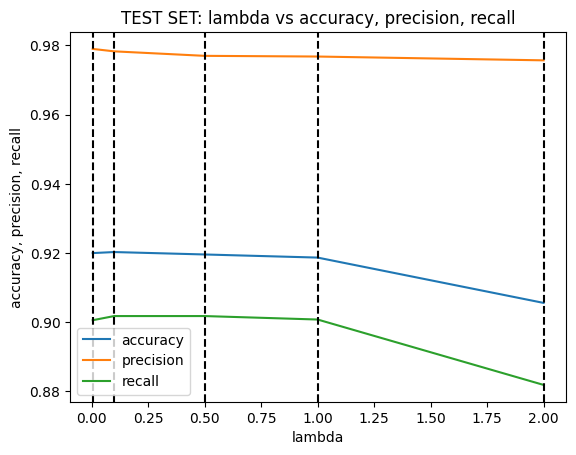

In [68]:
# save all the results in a list so it can be used for plotting

lambda_metrics = [0] * len(lambda_values)
# format: lambda_metrics[i] = [lambda, accuracy, precision, recall]

lambda_metrics[0] = [2.0, 0.9056, 0.9757, 0.8819]
lambda_metrics[1] = [1.0, 0.9187, 0.9768, 0.9008]
lambda_metrics[2] = [0.5, 0.9196, 0.9770, 0.9018]
lambda_metrics[3] = [0.1, 0.9203, 0.9783, 0.9018]
lambda_metrics[4] = [0.005, 0.9200, 0.9790, 0.9006]

# plot the results: lambda vs accuracy, precision, recall
plot = pd.DataFrame(lambda_metrics, columns = ['lambda', 'accuracy', 'precision', 'recall'])
plot.plot(x = 'lambda', y = ['accuracy', 'precision', 'recall'], kind = 'line')
# legend
# indicate line on the lambda values:
for i in range(len(lambda_values)):
    plt.axvline(x = lambda_values[i], color = 'black', linestyle = '--')
plt.legend(loc = 'lower left')
# title
plt.title('TEST SET: lambda vs accuracy, precision, recall')
# x-axis label
plt.xlabel('lambda')
# y-axis label
plt.ylabel('accuracy, precision, recall')
plt.show()
